# Traditional and Bayesian A/B testing

Traditional A/B testing resembles very much the scientific approach to hypothesis testing: formulate an hypothesis, design an experiment, collect data and perform statistical tests. This approach has been extensively used, and is a valid and overall accepted way to compare groups of observations and assess whether significant differences exist. It does however present drawbacks:
* it is sometimes non-intuitive to interpret the outcome
* it requires choices on how to perform multiple comparisons
* it requires a decision a-priori on how many data should be collected (eg a power analysis). These decision are not easy and sometimes a bit awkward...
* it should not be interrupted before completion, even if results seem clear

A more recent alternative was therefore developed to overcome these limitaitons. This solution relies on the bayesian concept of combining prior knowledge and new evidence to make an "optimal" decision on how to maximize your outcome. Of course, every new observation is remembered, and becomes prior knowledge when a new data is available. Therefore, these algorithms can easily adapt, which makes them suited for on-line implementations. Moreover, a trade-off can be defined between exploring new possibilities and exploiting promising strategies.

## Traditional A/B testing

First a quick example of a traditional test. We will look at a dataset where 2 advertisements are presented to different users, and we compare the advertisements based on how many time people clicked on the add ( click-trough rate). 

In [2]:
import pandas as pd
df = pd.read_csv('advertisement_clicks.csv', sep=",") 
df.head()

,advertisement_id,action
0,B,1
1,B,1
2,A,0
3,B,0
4,A,1


In [15]:
import numpy as np
from scipy import stats

group_A = df[df.advertisement_id == 'A'].action
group_B = df[df.advertisement_id == 'B'].action

[s, p] = stats.ttest_ind(group_A, group_B) # since we have a categorical independent variable (ad type) and a numerical dependent variable, we perform a t-test 

CTR_A = sum(group_A)/len(group_A)
CTR_B = sum(group_B)/len(group_B)
print('CTR for group A: %.2f' %CTR_A)
print('CTR for group A: %.2f' %CTR_B)
print('the groups are statisticaly different (p value = %.4f)' %p)



CTR for group A: 0.30
CTR for group A: 0.37
the groups are statisticaly different (p value = 0.0013)



Important: note that what we computed is "the probability of obtaining this result or a more extreme difference if the groups were generated by sampling from the same distribution". 
This is what I was refering to when I said it is not intuitive to interpret the outcome. Intuitively, we want to know the probability that the consumer behave differently depending on the ad shown. 

## Bayesian A/B testing
With this method, we don't need to design a study to assess differences between two (or more) versions. Instead, we let the algorithm adapt iteratively.

Here we will simulate an on-line experiment using 4 different ads (an A/B/C/D test, if you want). 

In [66]:
# Let's model the different ads as object

from scipy.stats import beta

class Ads(object):
  def __init__(self, p):
    self.p = p
    self.a = 1 # using a beta distribution as prior
    self.b = 1 # this choice of a and b parameters makes it a uniform prior
    self.data = []

  def show(self):
    click = np.random.random() < self.p
    return click

  def sample(self):
    return np.random.beta(self.a, self.b)

  def update(self, x):
    self.a += x
    self.b += 1 - x
    self.data.append(x) 



In [98]:
import matplotlib.pyplot as plt

def plot(ads, trial):
    x = np.linspace(0, 1, 200)
    
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    for ad in ads:
        y = beta.pdf(x, ad.a, ad.b)
        plt.plot(x, y, label="real p: %.4f" % ad.p)
    plt.title("Ads distributions after %s trials" % trial)
    plt.xlabel('Estimated click-through rate')
    plt.legend()
    
    plt.subplot(1,2,2)
    for ad in ads:
        cumulative_average_ctr = np.cumsum(ad.data) / (np.arange(len(ad.data))+1)
        plt.plot(cumulative_average_ctr, label="real p: %.4f" % ad.p)
        #plt.plot(np.ones(len(ad.data))*ad.p)

    plt.ylim((0,1))
    plt.legend()
        
    plt.savefig('result')
    plt.show()

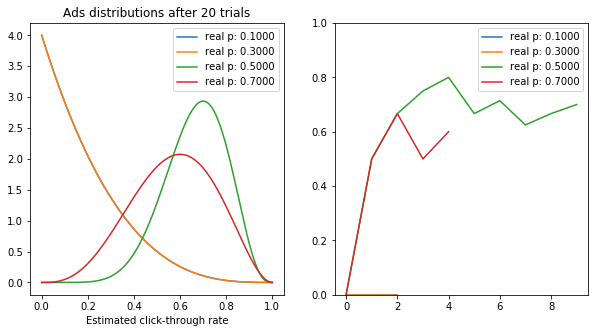

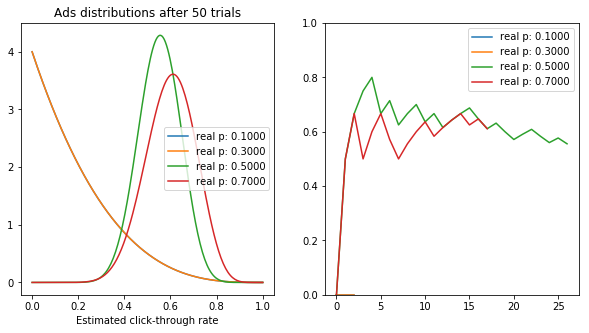

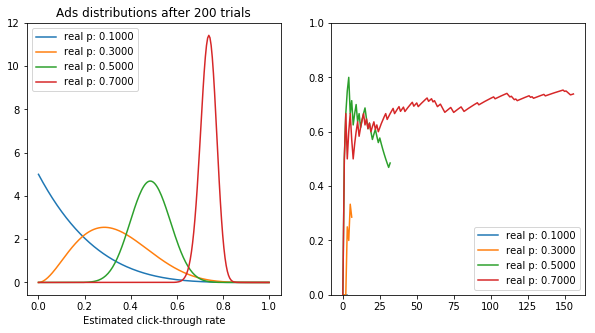

In [101]:
import numpy as np

NUM_TRIALS = 400
ads_CTR = [0.1, 0.3, 0.5, 0.7]
ads = [Ads(p) for p in ads_CTR]

plot_points = [20, 50, 200]

for i in range(NUM_TRIALS):
    
    # take a sample from each add
    idx = np.argmax([ad.sample() for ad in ads])
    
    # pull the arm for the bandit with the largest sample
    click = ads[idx].show() 
    
    # update the distribution for the ad we just presented
    ads[idx].update(click)
    
    if i in plot_points:
        plot(ads, i)

